In [2]:
import numpy as np
try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
import sys
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

def plotCurve(train_mean, train_std,test_mean,test_std,sizes):
    plt.plot(sizes, train_mean, 
            color='blue', marker='o', 
            markersize=5, 
            label='training accuracy')
    plt.fill_between(sizes, 
                  train_mean + train_std,
                   train_mean - train_std, alpha=0.15, color='blue')

    plt.plot(sizes, test_mean, 
              color='green', linestyle='--', 
              marker='s', markersize=5, 
             label='validation accuracy')
    plt.fill_between(sizes, 
                      test_mean + test_std,
                     test_mean - test_std, 
                    alpha=0.15, color='green')
    plt.xlabel('x_range')
    plt.ylabel('Accuracy')
    plt.show()
def likehoodScore(proba,y):
    return np.sum(proba * y)/proba.shape[0]

def firstNScore(n, pred, y):
    backup = np.array(pred, copy =True)
    for r in range(pred.shape[0]):
        row = backup[r]
        s = np.sort(row)
        for c in range(pred.shape[1]):
            temp = backup[r][c]
            backup[r][c] = False
            for j in range(1,n+1):
                if temp == s[-j]:
                    backup[r][c] = True
                    break
    res = np.sum(np.logical_and(backup,y))/pred.shape[0]
    return res               

def oneHotDecode(self, X_sample):
    result=None
    fiPos = 0
    colIndex = 0
    while colIndex < X_sample.shape[1]:
        if fiPos < len(self.ohe.n_values_) and colIndex == self.ohe.feature_indices_[fiPos]:                
            start = self.ohe.feature_indices_[fiPos]
            end_ = start+ self.ohe.n_values_[fiPos]
            #print("start{} end{}".format(start,end_))
            classes = np.argmax(X_sample[:,start:end_],axis=1).reshape(X_sample.shape[0],1)
            if result is None:
                result = classes
            else:
                result=np.hstack([result,classes])
            colIndex = end_
            fiPos = fiPos +1
        else:
            if result is None:
                result = X_sample[:,colIndex:colIndex+1]
            else:
                result=np.hstack([result, X_sample[:,colIndex:colIndex+1]])
            colIndex = colIndex +1
        
    return result 
def convertToDate(dayStamps):
    res = [] 
    for v in dayStamps:
        res.append(datetime.datetime.fromtimestamp(v*24*60*60))
    return res

#TODO confusion matrix ,e.g. 100 - 90 % precision
def _precisionClassify(df,proba, wins, c =0 ):
    for indx, v in enumerate(proba):
        row = 0
        col = 0
        if wins[indx] == c:
            col = 0
        else:
            col =1
        if v <0.2:
            row =6 
        elif v < 0.3 and  v >=0.2:
            row =5 
        elif v < 0.4 and v >= 0.3:
            row = 4 
        elif v < 0.5 and v >= 0.4:
            row = 3 
        elif v < 0.6 and v >= 0.5:
            row = 2 
        elif v < 0.8 and v >= 0.6:
            row = 1
        df.iloc[row,col] = df.iloc[row,col]+1 
    df[df.columns[2]] = df[df.columns[0]] /(df[df.columns[1]] + df[df.columns[0]])
    return df
    

def precisionMatrix(proba, y):
    rowHeader = ['>80','60-80','50-60','40-50','30-40','20-30','<20']
    df = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['h_Correct', 'h_Wrong','h_Precent'])
    hproba = proba[:,0]
    wins = np.argmax(y,axis=1)
    df = _precisionClassify(df,hproba,wins)
    temp = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['d_Correct', 'd_Wrong','d_Precent'])
    dproba = proba[:,1]
    df = df.join(_precisionClassify(temp,dproba,wins,c=1))
    temp = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['a_Correct', 'a_Wrong','a_Precent'])
    aproba = proba[:,2]
    df = df.join(_precisionClassify(temp,aproba,wins,c=2))
    return df
       
from datetime import date, timedelta
from sklearn.metrics import precision_score


def futureTest(mlp, X,y,numOfWeek = 10,verbose=False):
    decoded = oneHotDecode(c, X)
    dates = convertToDate(X[:,c.dateColumn])
    dates = [d - timedelta(days=2) for d in dates]    
    weeks  = [ v.isocalendar()[1] for v in dates]
    thisWeek = weeks[-1]
    start = -1
    last = X.shape[0]
    index = -1
    w = 0
    sum_proba =None 
    sum_y =None
    sum_train_proba=None
    sum_train_y=None
    while w < numOfWeek:
        if thisWeek != weeks[index]:
            start = X.shape[0] +index+1
            X_train = X[0:start, :]
            X_test = X[start:last,:]
            y_train = y[0:start,:]
            y_test = y[start:last,:]
            mlp.fit(X_train,y_train)
            decoded = oneHotDecode(c,X_test)
            home = np.array([c.inverseTeamMapping(decoded[:,0])]).reshape(X_test.shape[0],1)
            away = np.array([c.inverseTeamMapping(decoded[:,1])]).reshape(X_test.shape[0],1)
            stack = np.hstack([home,away])
            proba = mlp.predict_proba(X_test)
            train_proba =mlp.predict_proba(X_train)
            errorIndx = np.argmax(proba,axis=1) != np.argmax(y_test,axis=1)
            if sum_proba is None:
                sum_proba = proba
                sum_y = y_test
                sum_train_proba = train_proba
                sum_train_y = y_train
            else:
                sum_proba = np.vstack([sum_proba,proba])
                sum_y = np.vstack([sum_y,y_test])
                sum_train_proba = np.vstack([sum_train_proba, train_proba])
                sum_train_y= np.vstack([sum_train_y, y_train])
            if verbose == True:
                print("week{}".format(w))
                print("numOftest {} , score {}".format(X_test.shape[0],mlp.score(X_test,y_test)))
                print(np.hstack([stack[errorIndx],proba[errorIndx],y_test[errorIndx]]))
                print("first2 : {}",firstNScore(2,proba,y_test))
            last = start
            thisWeek = weeks[index]
            w = w+1
        index = index -1
        
    print("summary")
    print("score:")
    score = firstNScore(1,sum_proba,sum_y)
    print(score)
    print("2like")
    like2 = firstNScore(2,sum_proba,sum_y)
    print(precisionMatrix(sum_proba,sum_y))
    y_true= np.argmax(sum_y,axis=1)
    y_pred = np.argmax(sum_proba,axis=1)
    print("sum precision:{}".format(precision_score(y_true,y_pred,average=None)))
    return firstNScore(1,sum_train_proba,sum_train_y), score, like2


In [3]:
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
class FootballDataHelper:
    def __init__ (self, recentNum=5):
        self.win_mapping = {'H':0, 'D':1,'A':2}
        self.recentNum = recentNum
        self.df = None
        self.teamsData={}
        self.session = 0
        #self.hiddensCount = 2
       
        
    def readFootBallData(self,filename): 
        df = pd.read_csv(filename)
        #df = df.drop(df.columns[range(23,df.shape[1])], axis=1)
        #df = df.drop("Div",axis=1)
        df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
        df['session'] = pd.Series(np.ones(shape=(df.shape[0],))*self.session, index=df.index)
        self.session = self.session +1
        #df= df.drop('Referee', 1)
        #self.team = df['HomeTeam'].drop_duplicates()
        if self.df is None:
            self.df = df
        else:
            self.df = pd.concat([self.df,df])
            
        self.df = self.df.reset_index(drop=True)
        teams = self.df['HomeTeam'].drop_duplicates()
        teamMap = {}
        for index , v in enumerate(teams):
            teamMap[v] = index
        self.teamsMap = teamMap
        referees = self.df['Referee'].drop_duplicates()
        refereesMap = {}
        for index , v in enumerate(referees):
            refereesMap[v] = index+1

        self.refereesMap = refereesMap
 
    def getTeam(self,dataFrame, teamName):       
        return dataFrame[(dataFrame["HomeTeam"] == teamName) | (dataFrame["AwayTeam"] == teamName)]
 
        
    def previousRecords(self,team, date , recentNum):
        prev = team[( team["Date"] < date)]
        
        if prev.shape[0] < recentNum :
            #print("less than min Num")
            return None
        else:
            return prev.iloc[-recentNum:]
    def readPredict (self, filename):
        df = pd.read_csv(filename)
        df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

        return df
    
    
  
    def inverseTeamMapping (self, col):
        inverseMap ={}
        for name in self.teamsMap.keys():        
            inverseMap[self.teamsMap[name]] = name
        res =[]
        for idex, v in enumerate(col):
            res.append(inverseMap[v])
        return res


    def readTeamMatch(self, teamName):
        df = pd.read_csv('teams/'+teamName+'.csv')
        df['1'] = pd.to_datetime(df['1'],yearfirst=True)
        #df['1']= (pd.to_numeric(df['1'])/1e9/24/60/60)
        self.teamsData[teamName]=df.sort(['1'],ascending=[False])
        self.teamsById[self.teamsMap[teamName]]=self.teamsData[teamName]
    
    def commonMapping(self, X):
        X['HomeTeam'] = X['HomeTeam'].map(self.teamsMap)
        X['AwayTeam'] = X['AwayTeam'].map(self.teamsMap)
        X['Referee']=X['Referee'].map(self.refereesMap).fillna(0)
        X['HTR'] = X['HTR'].map(self.win_mapping)
        X['FTR'] = X['FTR'].map(self.win_mapping)
        return X
    def initData(self, X, target,encode):
        X  = X.sort_values(by="Date")
        isInput = False
        if target is None:
            target =X      
        else:
            if self.ohe is None:
                raise Exception("Not yet get train data")
            isInput = True
            if encode == True:
                target = self.commonMapping(target)
        y=None
        if encode == True:    
            X =self.commonMapping(X)
            y = []
            for v in target['FTR']:
                y.append(range(3)==v)
        else:
            y = target['FTR'].values
        target_date = (pd.to_numeric(target['Date'])/1e9/24/60/60).values
        return isInput, X,y, target, target_date
   
    def aggregate(self,recents,nonExpand,isInput,encode):
        res =None
        if encode == True:
            if isInput==False:
                self.ohe = OneHotEncoder(categorical_features='all')
                self.ohe.fit(recents)
            res = self.ohe.transform(recents).toarray()
        else:
            res = np.array(recents)
        self.dateColumn = res.shape[1]
        res = np.hstack([res,nonExpand])
        return res
    def _extractFromPrevious(self, prev,teamName):
        homes =  prev['HomeTeam'].values
        ftr = prev['FTR'].values
        homeGoals = prev['FTHG'].values
        awayGoals = prev['FTAG'].values
        homeYellow = prev['HY'].values
        awayYellow = prev['AY'].values
        homeRed = prev['HR'].values
        awayRed =prev['AR'].values
        rankdiffs = (prev['HAccP'].values+1) / (prev['AAccP'].values +1)
        scored = 0
        conceded = 0
        wins = 0
        draw =0
        lose = 0
        yellowCards = 0
        redCards = 0
        moral  = 0
        for i in range(ftr.shape[0]):
            if homes[i] == teamName:
                if ftr[i] == 'H' or ftr[i] == 0:
                    wins = wins+1
                    moral = moral + 3 * 1/rankdiffs[i]
                elif ftr[i] == 'A' or ftr[i] == 2:
                    lose = lose+1
                    moral = moral - 3 * rankdiffs[i]
                else:
                    draw = draw +1
                    moral = moral + 1 * 1/rankdiffs[i]
                scored = scored + homeGoals[i]
                conceded = conceded + awayGoals[i]
                yellowCards = yellowCards + homeYellow[i]
                redCards = redCards + homeRed[i]
                
                
            else:
                if ftr[i] == 'A' or ftr[i] == 2:
                    wins = wins+1
                    moral = moral + 3 * rankdiffs[i]
                elif ftr[i] == 'H' or ftr[i] == 0:
                    lose = lose+1
                    moral = moral - 3 * 1/rankdiffs[i]
                else:
                    draw = draw +1
                    moral = moral + 1 * rankdiffs[i]
                scored = scored + awayGoals[i]
                conceded = conceded + homeGoals[i]
                yellowCards = yellowCards + awayYellow[i]
                redCards = redCards + awayRed[i]
                              
        
        temp = np.array([wins,draw,lose,scored-conceded])
        return temp,moral
    def _getH7RecentMatches(self,x, X,teamName,recentNum,isHome):
        team = self.getTeam(X,teamName)
        homeOrAway = None
        if isHome == True:
            homeOrAway = X[X['HomeTeam']==teamName]
        else:
            homeOrAway = X[X['AwayTeam']==teamName]
        prev = self.previousRecords(team,x['Date'],recentNum)
        prevHomeOrAway = self.previousRecords(homeOrAway,x['Date'],recentNum)
        if prev is None or prevHomeOrAway is None:
            return None,None
        res1,moral= self._extractFromPrevious(prev,teamName)
        #res2= self._extractFromPrevious(prevHomeOrAway,teamName)
        
        return res1,moral
    def getH7(self,removeInsufficient=False, target=None,encode = True):
        #Simple recent win,draw, lose 
        df = self.df
        if removeInsufficient == True:
            df= df[df['Sufficient'] == 1]
        
        
        isInput, X, y,target, target_date = self.initData(df,target,encode)
        resy=[]
        resx=[]
        print("start format")
        recents = X[['HomeTeam','AwayTeam','Referee']].values
        haccp = X['HAccP'].values.reshape(X.shape[0],1)
        aaccp = X['AAccP'].values.reshape(X.shape[0],1)
        homeRecent = np.hstack([X[['HWin','HDraw','HLose']].values,
                                (X['HScore'].values - X['HConcede'].values).reshape(X.shape[0],1)])
        awayRecent = np.hstack([X[['AWin','ADraw','ALose']].values,
                                (X['AScore'].values - X['AConcede'].values).reshape(X.shape[0],1)])
        homeMoral = X['HMoral'].values.reshape(X.shape[0],1)
        awayMoral = X['AMoral'].values.reshape(X.shape[0],1)
        target_date = target_date.reshape(X.shape[0],1)
        nonExpand =np.hstack([target_date,X[['HRestDay','ARestDay','HAccS','AAccS','HAccST','AAccST']].values,haccp-aaccp,(haccp+1)/(aaccp+1),
                                homeRecent,awayRecent, homeMoral - awayMoral + haccp - aaccp])
        res = self.aggregate(recents,nonExpand,isInput,encode)
        print("finish")
        sys.stdout.flush()
        return res, np.array(y)
    def _getRank(self,x, X,teamName,recentNum):
        team = self.getTeam(X,teamName)
        prev = team[team['Date'] < x['Date']].values      
        for i in range(recentNum):
            pass
    def initRanking(self, n = 20):
        defaultPt = 1
        df = self.df.sort(columns=["Date"],ascending=[False])
        df["HPoints"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["APoints"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HAccP"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AAccP"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        hpoints= df["HPoints"].values
        apoints=df["APoints"].values
        ftr = df["FTR"].values
        for i in range(df.shape[0]):
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            if ftr[i] == 'H':
                hpoints[i] = 3
                apoints[i] = 0
            elif ftr[i] == 'D':
                hpoints[i] = 1
                apoints[i] = 1
            else :
                hpoints[i] = 0
                apoints[i] = 3
        df["HPoints"]=hpoints
        df["APoints"]=apoints
        for teamName in self.teamsMap.keys():
            print(teamName)
            team  = df[(df['HomeTeam']==teamName) | (df['AwayTeam'] == teamName)] 
            hometeam = team['HomeTeam'].values
            hpoints = team['HPoints'].values
            apoints = team['APoints'].values
            psum = 0
            haccp = team['HAccP'].values
            aaccp = team['AAccP'].values
        
            for  i in range(0,n):
                if i < hpoints.shape[0]:
                    psum = psum + (hpoints[i] if hometeam[i] == teamName else apoints[i] ) 
                else:
                    psum = psum + defaultPt        
                    
        
            for j in range(team.shape[0]):

                if j+n < hpoints.shape[0]:                     
                    psum = psum + (hpoints[j+n] if hometeam[j+n]==teamName else apoints[j+n])
                else:
                    psum = psum + defaultPt 
                
                psum = psum - (hpoints[j] if hometeam[j]==teamName else apoints[j])
                    
                if hometeam[j] == teamName:
                    haccp[j]=psum
                else:
                    aaccp[j]=psum
            team['HAccp']=haccp
            team['AAccP']=aaccp
            #print(team[['HomeTeam','AwayTeam','HAccP','AAccP']])
            df.update(team)
            
            #print(df[['HomeTeam','AwayTeam','HAccP','AAccP']])
        self.df =df
        return df
    def initRecentData(self, n =5):
        df = self.df.sort(columns=["Date"],ascending=[False])
        df["HWin"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AWin"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HDraw"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["ADraw"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HLose"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["ALose"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HScore"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AScore"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HConcede"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AConcede"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HMoral"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AMoral"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HRestDay"]= pd.Series(np.zeros(shape=(df.shape[0],)))
        df["ARestDay"]= pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HAccS"]= pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AAccS"]= pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HAccST"]= pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AAccST"]= pd.Series(np.zeros(shape=(df.shape[0],)))
        
        df["Sufficient"] = pd.Series(np.ones(shape=(df.shape[0],)))
        
        hscore = df['FTHG'].values
        ascore = df['FTAG'].values
        hconcede = df ['FTAG'].values
        aconcede = df['FTHG'].values
        hwin = df['HWin'].values
        awin = df['AWin'].values
        hlose = df['HLose'].values
        alose = df['ALose'].values
        hdraw = df['HDraw'].values
        adraw = df['ADraw'].values
        hmoral = df['HMoral'].values
        amoral = df['AMoral'].values
        
        rankRatio = (df['HAccP'].values+1) / (df['AAccP'].values +1)
        
        
        ftr = df["FTR"].values
        for i in range(df.shape[0]):
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            if ftr[i] == 'H':
                hwin[i] = 1
                hmoral[i] = 3 * 1/rankRatio[i]
                alose[i]= 1
                amoral[i] = -3 * 1/rankRatio[i]
            elif ftr[i] == 'D':
                hdraw[i] = 1
                hmoral[i] = 1 * 1/rankRatio[i]
                adraw[i] = 1
                amoral[i] = 1 * rankRatio[i]
            else :
                hlose[i] = 1
                hmoral[i] = -3*rankRatio[i]
                awin [i] = 1
                amoral[i] = 3*rankRatio[i]
        
        
        df["HWin"]=hwin
        df["AWin"]=awin
        df["HDraw"]=hdraw
        df["ADraw"]=adraw
        df["HLose"]=hlose
        df["ALose"]=alose
        df["HScore"]=hscore
        df["AScore"]=ascore
        df["HConcede"]=hconcede
        df["AConcede"]=aconcede
        df["HMoral"] = hmoral
        df["AMoral"] = amoral
        
        
        
        for teamName in self.teamsMap.keys():
            print(teamName)
            team  = df[(df['HomeTeam']==teamName) | (df['AwayTeam'] == teamName)] 
            hometeam = team['HomeTeam'].values
            hwin = team["HWin"].values
            awin = team["AWin"].values
            hlose= team["HLose"].values
            alose = team["ALose"].values
            hdraw = team["HDraw"].values
            adraw = team["ADraw"].values
            hscore = team["HScore"].values
            ascore = team["AScore"].values
            hconcede = team["HConcede"].values
            aconcede = team["AConcede"].values
            hmoral = team["HMoral"].values
            amoral = team["AMoral"].values
            hrestday = team["HRestDay"].values
            arestday = team["ARestDay"].values
            
            hs= team["HS"].values
            as_ = team["AS"].values
            hst = team["HST"].values
            ast = team["AST"].values
            haccs = team["HAccS"].values
            aaccs = team["AAccS"].values
            haccst =team["HAccST"].values
            aaccst = team["AAccST"].values
            
            matchDate =team['Date'].values
            sufficient = team['Sufficient'].values
            teamMatchesDate = self.teamsData[teamName].sort('1',ascending=False)['1'].values
            
            restday = 0
            winsum =0 
            losesum=0
            drawsum=0
            scoresum =0
            concedesum=0
            accs = 0
            accst = 0
            moralsum = 0
            #print(team[['HomeTeam','AwayTeam','HWin']])
            for  i in range(0,n):
                if i < team.shape[0]:
                    scoresum = scoresum + (hscore[i] if hometeam[i] == teamName else ascore[i])
                    winsum = winsum + (hwin[i] if hometeam[i] == teamName else awin[i])
                    losesum= losesum + (hlose[i] if hometeam[i] == teamName else alose[i])
                    drawsum= drawsum + (hdraw[i] if hometeam[i] == teamName else adraw[i])
                    concedesum = concedesum+ (hconcede[i] if hometeam[i] == teamName else aconcede[i])
                    moralsum= moralsum+ (hmoral[i] if hometeam[i] == teamName else amoral[i])
                    accs = accs + (hs[i] if hometeam[i] == teamName else as_[i])
                    accst = accst + (hst[i] if hometeam[i] == teamName else ast[i])
                else:
                    # + 0
                    pass
            dateIndx = 0
            for j in range(team.shape[0]):
                while True:
                    if dateIndx >= teamMatchesDate.shape[0]:
                        sufficient[j] = False
                        break
                    if teamMatchesDate[dateIndx] < matchDate[j] :
                        restday = (matchDate[j] - teamMatchesDate[dateIndx])/np.timedelta64(1,'D')
                        break
                    else:
                        dateIndx = dateIndx + 1
                
                if j+n < team.shape[0]:                     
                    scoresum = scoresum + (hscore[j+n] if hometeam[j+n] == teamName else ascore[j+n])
                    winsum = winsum + (hwin[j+n] if hometeam[j+n] == teamName else awin[j+n])
                    losesum= losesum + (hlose[j+n] if hometeam[j+n] == teamName else alose[j+n])
                    drawsum= drawsum + (hdraw[j+n] if hometeam[j+n] == teamName else adraw[j+n])
                    concedesum = concedesum+ (hconcede[j+n] if hometeam[j+n] == teamName else aconcede[j+n])
                    moralsum= moralsum+ (hmoral[j+n] if hometeam[j+n] == teamName else amoral[j+n])
                    accs = accs + (hs[j+n] if hometeam[j+n] == teamName else as_[j+n])
                    accst = accst + (hst[j+n] if hometeam[j+n] == teamName else ast[j+n])
                else:
                    sufficient[j] = False
                    
                
                scoresum = scoresum - (hscore[j] if hometeam[j] == teamName else ascore[j])
                winsum = winsum - (hwin[j] if hometeam[j] == teamName else awin[j])
                losesum= losesum - (hlose[j] if hometeam[j] == teamName else alose[j])
                drawsum= drawsum - (hdraw[j] if hometeam[j] == teamName else adraw[j])
                concedesum = concedesum - (hconcede[j] if hometeam[j] == teamName else aconcede[j])
                moralsum= moralsum - (hmoral[j] if hometeam[j] == teamName else amoral[j])
                accs = accs - (hs[j] if hometeam[j] == teamName else as_[j])
                accst = accst - (hst[j] if hometeam[j] == teamName else ast[j])
                    
                if hometeam[j] == teamName:
                    hscore[j] = scoresum
                    hwin[j] = winsum
                    hlose[j] = losesum
                    hdraw[j] = drawsum
                    hconcede[j] = concedesum
                    hmoral[j] = moralsum
                    hrestday[j] = restday
                    haccs[j]=accs
                    haccst[j]=accst
                else:
                    ascore[j] = scoresum
                    awin[j] = winsum
                    alose[j] = losesum
                    adraw[j] = drawsum
                    aconcede[j] = concedesum
                    amoral[j] = moralsum
                    arestday[j] = restday
                    aaccs[j] = accs
                    aaccst[j] = accst
            team["HWin"]=hwin
            team["AWin"]=awin
            team["HDraw"]=hdraw
            team["ADraw"]=adraw
            team["HLose"]=hlose
            team["ALose"]=alose
            team["HScore"]=hscore
            team["AScore"]=ascore
            team["HConcede"]=hconcede
            team["AConcede"]=aconcede
            team["HMoral"] = hmoral
            team["AMoral"] = amoral
            team['Sufficient'] = sufficient
            team['HAccS'] = haccs
            team['AAccS'] = aaccs
            team['HAccST'] = haccst
            team['AAccST'] = aaccst
        
            #print(team[['HomeTeam','AwayTeam','HWin']])
            df.update(team)
            #print(df[['HomeTeam','AwayTeam','HAccP','AAccP']])
        self.df =df
        return df
    def initTeamData(self):
        self.teamsData={}
        self.teamsById={}
        for name in self.teamsMap.keys():
            self.readTeamMatch(name)
            

/home/y/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
c = FootballDataHelper()
#c.readFootBallData("E0_1112.csv")
c.readFootBallData("E0_1213.csv")
c.readFootBallData("E0_1314.csv")
c.readFootBallData("E0_1415.csv")
c.readFootBallData("E0 (1).csv")
c.initTeamData()

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [5]:
df = c.initRanking()

 progress 1432

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Hull
West Ham
Stoke
Watford
Fulham
Burnley
Wigan
Newcastle
Man City
Chelsea
Leicester
Aston Villa
Reading
West Brom
Southampton
Cardiff
Swansea
Norwich
Crystal Palace
Bournemouth
Sunderland
Everton
Man United
Arsenal
QPR
Liverpool
Tottenham


/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
df=c.initRecentData(n=5)

 progress 1432

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:284: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:388: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:467: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:468: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/y/anaconda

Hull
West Ham
Stoke
Watford
Fulham
Burnley
Wigan
Newcastle
Man City
Chelsea
Leicester
Aston Villa
Reading
West Brom
Southampton
Cardiff
Swansea
Norwich
Crystal Palace
Bournemouth
Sunderland
Everton
Man United
Arsenal
QPR
Liverpool
Tottenham


/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:483: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [37]:
X,y = c.getH7(removeInsufficient = True)


start format
finish


In [38]:
%matplotlib qt
def plotErrorDate(X_test, X_err, dateCol = 10):
    X_test_date =np.sort(X_test[:,c.dateColumn])
    X_date=[]
    y_date=[]
    for v in X_test_date:
        date = datetime.datetime.fromtimestamp(v*24*60*60)
        if len(X_date) ==0  or X_date[-1] != date:
            X_date.append(date)
            y_date.append(1)
        else:
            y_date[-1] = y_date[-1] +1
    plt.plot_date(X_date,y_date,xdate=True)
    X_err_d = np.sort(X_err[:,c.dateColumn])
    X_err_date=[]
    y_err_date = []
    for v in X_err_d:
        date = datetime.datetime.fromtimestamp(v*24*60*60)
        if len(X_err_date) ==0  or X_err_date[-1] != date:
            X_err_date.append(date)
            y_err_date.append(1)
        else:
            y_err_date[-1] = y_err_date[-1] +1
    plt.plot_date(X_err_date,y_err_date,xdate=True,color='red')
    plt.show()



In [184]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
g_hiddenNodes = int(45)
g_alpha = 0 
clf = SoftMaxMLPClassifier(hidden_layer_sizes=[g_hiddenNodes], activation='logistic', algorithm='l-bfgs', alpha=g_alpha, 
              learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=1000,early_stopping = False,verbose = 3)
mlp = Pipeline([ ('scl', StandardScaler()),('clf', clf)])

In [185]:
mlp.fit(X,y)

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SoftMaxMLPClassifier(activation='logistic', algorithm='l-bfgs', alpha=0,
           batch_size='auto', beta_1=0.9, beta_2=0.999,
           early_stopping=False, epsilon=1e-08, hidden_layer_sizes=[45],
           learn...e=None, shuffle=True, tol=0.0001,
           validation_fraction=0.1, verbose=3, warm_start=False))])

In [9]:
print ("start learning")
sys.stdout.flush()
train_sizes, train_scores, test_scores = learning_curve(estimator=mlp, 
                       X=X, 
                      y=y, 
                      train_sizes=np.linspace(0.1, 1.0, 4), 
                      cv=4,
                     n_jobs=1,verbose=3)
print("finishing")   
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


print(test_mean)

start learning
[learning_curve] Training set sizes: [ 101  404  707 1011]
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.433234 -   0.8s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.522255 -   0.7s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.531157 -   0.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.516320 -   1.2s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.468843 -   0.2s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.572700 -   0.5s
[CV] no parameters to be set .........................................
[CV

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    9.3s finished


In [10]:
learningRes = np.vstack([train_sizes,train_mean,train_std,test_mean,test_std]).T


In [11]:
learningDf = pd.DataFrame(learningRes,columns=['size','train_mean','train_std','test_mean','test_std'])
print(learningDf)

   size  train_mean  train_std  test_mean  test_std
0   101    0.443069   0.012862   0.442136  0.022793
1   404    0.552599   0.011394   0.534125  0.032843
2   707    0.566124   0.011376   0.537834  0.031916
3  1011    0.560584   0.012732   0.537092  0.038059


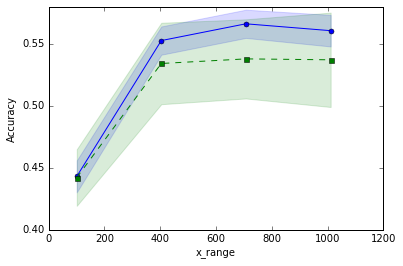

In [12]:
%matplotlib inline
plotCurve(train_mean,train_std,test_mean,test_std,train_sizes)


In [13]:
from sklearn.cross_validation import StratifiedKFold
def crossValidate(mlp, X,y, fold = 10):
    y_label = np.argmax(y,axis=1)

    kfold = StratifiedKFold(y=y_label, 
                             n_folds=fold,
                            random_state=1)

    scores = []
    train_scores=[]
    firstNScores = []
    for k, (train, test) in enumerate(kfold):

        mlp.fit(X[train], y[train])
        score = mlp.score(X[test], y[test])
        firstNScores.append(firstNScore(2, mlp.predict_proba(X[test]), y[test]))
        train_scores.append(mlp.score(X[train],y[train]))
        scores.append(score)
        print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, 
                    np.bincount(y_label[train]), score))    
        
        
    return train_scores,scores, firstNScores



Fold: 1, Class dist.: [521 288 369], Acc: 0.529
Fold: 2, Class dist.: [521 288 369], Acc: 0.500
Fold: 3, Class dist.: [521 289 369], Acc: 0.503
Fold: 4, Class dist.: [521 289 369], Acc: 0.497
Fold: 5, Class dist.: [522 289 369], Acc: 0.512
Fold: 6, Class dist.: [522 289 369], Acc: 0.542
Fold: 7, Class dist.: [522 289 370], Acc: 0.467
Fold: 8, Class dist.: [522 289 370], Acc: 0.485
lamda: 0, train: 0.616782390635193, test: 0.504384875207568
Fold: 1, Class dist.: [521 288 369], Acc: 0.518
Fold: 2, Class dist.: [521 288 369], Acc: 0.500
Fold: 3, Class dist.: [521 289 369], Acc: 0.538
Fold: 4, Class dist.: [521 289 369], Acc: 0.515
Fold: 5, Class dist.: [522 289 369], Acc: 0.518
Fold: 6, Class dist.: [522 289 369], Acc: 0.589
Fold: 7, Class dist.: [522 289 370], Acc: 0.443
Fold: 8, Class dist.: [522 289 370], Acc: 0.479
lamda: 2, train: 0.6026860271530378, test: 0.5125250053073704
Fold: 1, Class dist.: [521 288 369], Acc: 0.518
Fold: 2, Class dist.: [521 288 369], Acc: 0.482
Fold: 3, Class

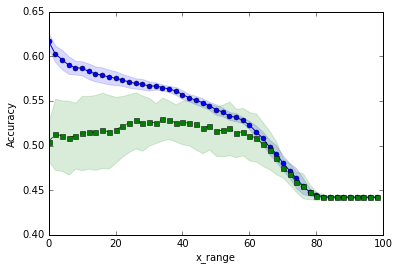

In [28]:

def lamda_test(mlp, X, y, lamdas):
    
    train_scores=[]
    test_scores=[]
    for lamda in lamdas:
        clf.set_params(alpha= lamda)
        train_s, test_s, firstNScores = crossValidate(mlp,X,y,fold=8)
      #  train_s, test_s, firstNScores =futureTest(mlp,X,y,numOfWeek=20) 
        train_scores.append(train_s)
        test_scores.append(test_s)
        print("lamda: {}, train: {}, test: {}".format(lamda, 
                    np.mean(train_s), np.mean(test_s)) )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plotCurve(train_mean,train_std,test_mean,test_std,lamdas)
    return np.array(train_scores),np.array(test_scores)

l_range = []
for i in range(0,50):
    l_range.append(2*i)
train_scores,test_scores = lamda_test(mlp,X,y,np.array(l_range))
#50

In [15]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
alphaRes = np.vstack([l_range,train_mean,train_std,test_mean,test_std]).T
alphaDf = pd.DataFrame(alphaRes,columns=['alpha','train_mean','train_std','test_mean','test_std'])
print(alphaDf)

   alpha  train_mean  train_std  test_mean  test_std
0      0    1.000000   0.000000   0.401954  0.026798
1     10    0.672959   0.008925   0.503574  0.042680
2     20    0.574076   0.006799   0.514748  0.038951
3     30    0.562528   0.004899   0.524351  0.037521
4     40    0.558923   0.004739   0.533285  0.028010
5     50    0.556592   0.004154   0.534782  0.021022
6     60    0.552034   0.003219   0.530322  0.019796
7     70    0.547369   0.004033   0.527390  0.018763
8     80    0.544083   0.005118   0.528103  0.025373
9     90    0.535076   0.005195   0.523638  0.027085


In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt
def testNodeSize(start ,end):
    node_range = range(start,end,5)
    train_means = []
    train_std = []
    test_means =[]
    test_std=[]
    for node in node_range:   
        print("start node:{}".format(node))
        clf = SoftMaxMLPClassifier(hidden_layer_sizes=[node], activation='logistic', algorithm='l-bfgs', alpha=0, 
                  learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=500,early_stopping = True,verbose = 3)
        mlp = Pipeline([('scl', StandardScaler()),('clf', clf)])
        train_scores,test_scores,first2 = crossValidate(mlp,X,y,fold=8)
      #  train_scores,test_scores , first2= futureTest(mlp, X,y,numOfWeek = 10)
        train_means.append(np.mean(train_scores))
        train_std.append(np.std(train_scores))
        test_means.append(np.mean(test_scores))
        test_std.append(np.std(test_scores))
        print("Node {}: train_mean {}  v.s. test_mean {}".format(node,np.mean(train_scores),np.mean(test_scores)))
    plotCurve(np.array(train_means),np.array(train_std),np.array(test_means),np.array(test_std),np.array(node_range))
    return node_range, train_means,train_std,test_means,test_std

In [24]:
node_range, train_means,train_std,test_means,test_std=testNodeSize(1,X.shape[1] )

start node:1
Fold: 1, Class dist.: [521 288 369], Acc: 0.500
Fold: 2, Class dist.: [521 288 369], Acc: 0.506
Fold: 3, Class dist.: [521 289 369], Acc: 0.503
Fold: 4, Class dist.: [521 289 369], Acc: 0.497
Fold: 5, Class dist.: [522 289 369], Acc: 0.470
Fold: 6, Class dist.: [522 289 369], Acc: 0.560
Fold: 7, Class dist.: [522 289 370], Acc: 0.467
Fold: 8, Class dist.: [522 289 370], Acc: 0.443
Node 1: train_mean 0.6094788099756978  v.s. test_mean 0.4932279873027055
start node:6
Fold: 1, Class dist.: [521 288 369], Acc: 0.400
Fold: 2, Class dist.: [521 288 369], Acc: 0.424
Fold: 3, Class dist.: [521 289 369], Acc: 0.497
Fold: 4, Class dist.: [521 289 369], Acc: 0.467
Fold: 5, Class dist.: [522 289 369], Acc: 0.458
Fold: 6, Class dist.: [522 289 369], Acc: 0.500
Fold: 7, Class dist.: [522 289 370], Acc: 0.431
Fold: 8, Class dist.: [522 289 370], Acc: 0.431
Node 6: train_mean 0.7877269876379113  v.s. test_mean 0.4510794044524942
start node:11
Fold: 1, Class dist.: [521 288 369], Acc: 0.41

KeyboardInterrupt: 

In [18]:
nodeRes = np.vstack([node_range,train_means,train_std,test_means,test_std]).T
nodeDf = pd.DataFrame(nodeRes,columns=['nodeNum','train_mean','train_std','test_mean','test_std'])
print(nodeDf)

    nodeNum  train_mean  train_std  test_mean  test_std
0         4    0.738541   0.018985   0.453907  0.033229
1         9    0.874104   0.011133   0.430907  0.024683
2        14    0.944788   0.006366   0.433094  0.044951
3        19    0.983681   0.005758   0.437647  0.033397
4        24    0.997878   0.003260   0.426508  0.035193
5        29    0.999576   0.000600   0.432443  0.023766
6        34    1.000000   0.000000   0.428568  0.049071
7        39    1.000000   0.000000   0.432368  0.043109
8        44    1.000000   0.000000   0.433975  0.019339
9        49    0.999894   0.000280   0.418455  0.034480
10       54    1.000000   0.000000   0.439052  0.041520
11       59    1.000000   0.000000   0.430911  0.029448
12       64    1.000000   0.000000   0.431761  0.019038
13       69    1.000000   0.000000   0.422863  0.033736
14       74    1.000000   0.000000   0.433068  0.037790
15       79    1.000000   0.000000   0.434675  0.021340
16       84    1.000000   0.000000   0.433121  0

In [19]:
clf.set_params(alpha=g_alpha)
print(clf)
train_score, test_score, first2 = futureTest(mlp,X,y,numOfWeek = 30, verbose=True)      


SoftMaxMLPClassifier(activation='logistic', algorithm='l-bfgs', alpha=35,
           batch_size='auto', beta_1=0.9, beta_2=0.999,
           early_stopping=True, epsilon=1e-08, hidden_layer_sizes=[40],
           learning_rate='adaptive', learning_rate_init=0.01,
           max_iter=1000, momentum=0.9, nesterovs_momentum=True,
           power_t=0.5, random_state=None, shuffle=True, tol=0.0001,
           validation_fraction=0.1, verbose=3, warm_start=False)
week0
numOftest 5 , score 0.6
[['Norwich' 'Man City' '0.2414653770354599' '0.24387811092735376'
  '0.5146565120371863' 'False' 'True' 'False']
 ['Stoke' 'Southampton' '0.6596315044458729' '0.16004793758742336'
  '0.18032055796670357' 'False' 'False' 'True']]
first2 : {} 1.0
week1
numOftest 10 , score 0.4
[['Everton' 'West Ham' '0.5270087906910846' '0.2187384515293811'
  '0.2542527577795343' 'False' 'False' 'True']
 ['Newcastle' 'Bournemouth' '0.29281329427594227' '0.4136981061070198'
  '0.2934885996170378' 'False' 'False' 'True']
 

/home/y/scikit-learn/sklearn/metrics/classification.py:1098: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([ 0.56491228,  0.        ,  0.54862843])

In [98]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt
def testRecentNum(start, end):
    recent_range = range(start,end)
    train_means = []
    train_std = []
    test_means =[]
    test_std=[]
    first2_mean=[]
    for recent in recent_range:
        print("start recent:{}".format(recent))
        X,y = c.getH7(recent)
        clf = SoftMaxMLPClassifier(hidden_layer_sizes=[g_alpha], activation='logistic', algorithm='l-bfgs', alpha=g_alpha, 
                  learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=500,early_stopping = True,verbose = 3)
        mlp = Pipeline([('scl', StandardScaler()),('clf', clf)])
        train_scores,test_scores, first2 = crossValidate(mlp,X,y,fold=10)
        #train_scores,test_scores, first2 = futureTest(mlp, X,y,numOfWeek = 15)
        train_means.append(np.mean(train_scores))
        train_std.append(np.std(train_scores))
        test_means.append(np.mean(test_scores))
        test_std.append(np.std(test_scores))
        first2_mean.append(np.mean(first2))
        print("recent {}: train_mean {}  v.s. test_mean {} , first2_mean {}".format(
                recent,np.mean(train_scores),np.mean(test_scores),np.mean(first2)))
    plotCurve(np.array(train_means),np.array(train_std),np.array(test_means),np.array(test_std),np.array(recent_range))
    return train_means,train_std,test_means,test_std,first2_mean



start recent:1
start format
 progress 1432finish
Fold: 1, Class dist.: [554 314 389], Acc: 0.532
Fold: 2, Class dist.: [554 314 389], Acc: 0.532
Fold: 3, Class dist.: [554 314 389], Acc: 0.546
Fold: 4, Class dist.: [554 314 390], Acc: 0.557
Fold: 5, Class dist.: [554 314 390], Acc: 0.543
Fold: 6, Class dist.: [554 314 390], Acc: 0.514
Fold: 7, Class dist.: [555 314 390], Acc: 0.511
Fold: 8, Class dist.: [555 314 390], Acc: 0.525
Fold: 9, Class dist.: [555 314 390], Acc: 0.475
Fold: 10, Class dist.: [555 315 390], Acc: 0.486
recent 1: train_mean 0.5517397415529908  v.s. test_mean 0.5220513405583185 , first2_mean 0.7603244144475618
start recent:2
start format
 progress 1432finish
Fold: 1, Class dist.: [542 300 385], Acc: 0.558
Fold: 2, Class dist.: [542 300 385], Acc: 0.514
Fold: 3, Class dist.: [542 300 385], Acc: 0.536
Fold: 4, Class dist.: [543 300 385], Acc: 0.540
Fold: 5, Class dist.: [543 301 385], Acc: 0.500
Fold: 6, Class dist.: [543 301 385], Acc: 0.522
Fold: 7, Class dist.: [54

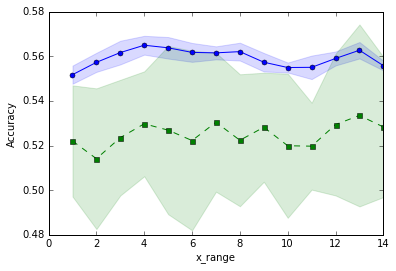

In [99]:
train_means,train_std,test_means,test_std,first2_mean=testRecentNum(1 ,15)

In [ ]:

proba = mlp.predict_proba(X_test)
precisionMatrix(proba,y_test)



In [ ]:
#future
mlp.fit(X,y)
inData = c.readPredict("future.csv")
print(inData)
X_in, y_in = c.getH6(5,target=inData)
res = mlp.predict(X_in)
proba= mlp.predict_proba(X_in)
print(mlp.score(X_in,y_in))
print (np.hstack([proba,y_in]))


In [ ]:
return
print(X.shape)

In [12]:
X,y = c.getH7(removeInsufficient=True, encode=False)


start format
finish


In [13]:
print(X.shape)
df = pd.DataFrame(np.hstack([X,y.reshape(y.shape[0],1)]))

df.columns = ['home','away','Referee','time','HRestTime','ARestTime','HAccS','AAccS','HAccST','AAccST'
              ,'HAccP - AAccP','H/A','HWin','HDraw','HLose','H goal Diff',
'AWin','ADraw','ALose','A goal diff','moraldiff + h-a',
              'y']
print(df)

(1348, 21)
                home            away        Referee   time HRestTime  \
0             Fulham        Man City       M Halsey  15612         7   
1         Man United       Tottenham          C Foy  15612         2   
2              Stoke         Swansea         J Moss  15612         7   
3            Norwich       Liverpool        M Jones  15612         2   
4            Everton     Southampton      L Probert  15612         3   
5            Arsenal         Chelsea     M Atkinson  15612         2   
6        Aston Villa       West Brom       A Taylor  15613         4   
7                QPR        West Ham  M Clattenburg  15614         4   
8              Wigan         Everton       K Friend  15619         7   
9           West Ham         Arsenal         P Dowd  15619         4   
10         West Brom             QPR        M Jones  15619         6   
11           Swansea         Reading         M Dean  15619         7   
12          Man City      Sunderland      L Probert  

In [14]:

df.to_csv('dataSet/moral.csv',index=False)

In [1]:
import numpy as np
import theano
import theano.tensor as T

import lasagne

In [92]:
X,y = c.getH7(removeInsufficient = True)

start format
finish


In [93]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

In [148]:
from sklearn.cross_validation import train_test_split
def splitData(X,y):
    X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)
    X_test, X_val, y_test,y_val = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [149]:
from keras.models import Sequential


In [178]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
def createModel(hidSize):
    model = Sequential()
    model.add(Dense(hidSize[0], input_dim=X.shape[1], init='glorot_normal'))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.5))

    model.add(Dense(hidSize[1], init='glorot_normal'))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.5))

    model.add(Dense(3, init='glorot_normal'))
    model.add(Activation('softmax'))
    sgd = SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')
    return model
model=createModel([64,64])
earlyCallback = EarlyStopping(patience=20,verbose=1)

In [179]:
history = model.fit(X_scaled,y,verbose=1,nb_epoch=500, validation_split=0.1,show_accuracy=True, callbacks=[earlyCallback])

Train on 1213 samples, validate on 135 samples
Epoch 1/500
1213/1213 [==============================] - 0s - loss: 1.2625 - acc: 0.3685 - val_loss: 1.0888 - val_acc: 0.4296
Epoch 2/500
1213/1213 [==============================] - 0s - loss: 1.1990 - acc: 0.3825 - val_loss: 1.0669 - val_acc: 0.4296
Epoch 3/500
1213/1213 [==============================] - 0s - loss: 1.1644 - acc: 0.3792 - val_loss: 1.0598 - val_acc: 0.4519
Epoch 4/500
1213/1213 [==============================] - 0s - loss: 1.1022 - acc: 0.4328 - val_loss: 1.0544 - val_acc: 0.4519
Epoch 5/500
1213/1213 [==============================] - 0s - loss: 1.1111 - acc: 0.4279 - val_loss: 1.0481 - val_acc: 0.4593
Epoch 6/500
1213/1213 [==============================] - 0s - loss: 1.0747 - acc: 0.4345 - val_loss: 1.0506 - val_acc: 0.4963
Epoch 7/500
1213/1213 [==============================] - 0s - loss: 1.0629 - acc: 0.4534 - val_loss: 1.0405 - val_acc: 0.4815
Epoch 8/500
1213/1213 [==============================] - 0s - loss: 1.0

In [186]:
model.evaluate(X_scaled,y)

1348/1348 [==============================] - 0s     


0.8903485469365332

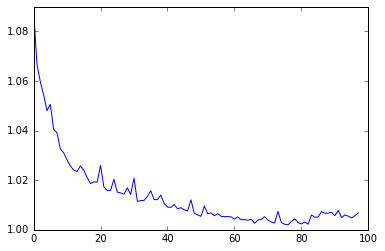

In [187]:
%matplotlib inline
import matplotlib.pyplot as plt
x_range = range(len(history.history['val_loss']))
plt.plot(x_range,history.history['val_loss'])
plt.show()

In [218]:
from sklearn.cross_validation import StratifiedKFold
def crossValidate2(model, X,y, fold = 10):
    y_label = np.argmax(y,axis=1)

    kfold = StratifiedKFold(y=y_label, 
                             n_folds=fold,
                            random_state=1)

    scores = []
    train_scores=[]
    proba_test = []
    proba_y=[]
    for k, (train, test) in enumerate(kfold):
        earlyCallback = EarlyStopping(patience=20,verbose=1)
        history = model.fit(X_scaled,y,verbose=1,nb_epoch=500, validation_split=0.1,show_accuracy=True, callbacks=[earlyCallback])
      #  firstNScores.append(firstNScore(2, model.predict_proba(X[test]), y[test]))
        score = model.evaluate(X[test],y[test])
        proba_test.append(model.predict_proba(X[test]))
        proba_y.append(y[test])
        train_scores.append(model.evaluate(X[train],y[train]))
        scores.append(score)
        print('Fold: %s, Class dist.: %s, val_loss: %.3f' % (k+1, 
                    np.bincount(y_label[train]), score))    
        
        
    return train_scores,scores, proba_test,proba_y




In [194]:
train_scores,scores, proba_test,proba_y = crossValidate2(model,X_scaled,y,fold=5)

Train on 1213 samples, validate on 135 samples
Epoch 1/500
1213/1213 [==============================] - 0s - loss: 0.8406 - acc: 0.5911 - val_loss: 0.8669 - val_acc: 0.5778
Epoch 2/500
1213/1213 [==============================] - 0s - loss: 0.8609 - acc: 0.6010 - val_loss: 0.8678 - val_acc: 0.5852
Epoch 3/500
1213/1213 [==============================] - 0s - loss: 0.8602 - acc: 0.5903 - val_loss: 0.8699 - val_acc: 0.5926
Epoch 4/500
1213/1213 [==============================] - 0s - loss: 0.8322 - acc: 0.6010 - val_loss: 0.8701 - val_acc: 0.5926
Epoch 5/500
1213/1213 [==============================] - 0s - loss: 0.8512 - acc: 0.5969 - val_loss: 0.8710 - val_acc: 0.5778
Epoch 6/500
1213/1213 [==============================] - 0s - loss: 0.8344 - acc: 0.5960 - val_loss: 0.8710 - val_acc: 0.5926
Epoch 7/500
1213/1213 [==============================] - 0s - loss: 0.8433 - acc: 0.6183 - val_loss: 0.8722 - val_acc: 0.5852
Epoch 8/500
1213/1213 [==============================] - 0s - loss: 0.8

In [198]:
def testNodeNum(X,y, sizes):
    train_loss=[] 
    score_loss=[]
    for s in sizes:
        model=createModel([s,s])
        train_scores,scores, firstNScores = crossValidate2(model,X,y,fold=5)
        print("size:{} , val_loss_mean:{}".format(s,np.mean(scores)))
        train_loss.append(train_scores)
        score_loss.append(scores)
    return train_loss,score_loss

In [ ]:
sizes= range(5,X.shape[1],5)
train_loss,score_loss= testNodeNum(X_scaled,y,sizes)

Train on 1213 samples, validate on 135 samples
Epoch 1/500
1213/1213 [==============================] - 0s - loss: 1.5632 - acc: 0.2679 - val_loss: 1.3519 - val_acc: 0.2519
Epoch 2/500
1213/1213 [==============================] - 0s - loss: 1.4029 - acc: 0.2819 - val_loss: 1.2532 - val_acc: 0.2519
Epoch 3/500
1213/1213 [==============================] - 0s - loss: 1.3606 - acc: 0.2844 - val_loss: 1.1842 - val_acc: 0.2519
Epoch 4/500
1213/1213 [==============================] - 0s - loss: 1.2405 - acc: 0.3314 - val_loss: 1.1401 - val_acc: 0.2444
Epoch 5/500
1213/1213 [==============================] - 0s - loss: 1.2314 - acc: 0.3388 - val_loss: 1.1116 - val_acc: 0.2667
Epoch 6/500
1213/1213 [==============================] - 0s - loss: 1.1942 - acc: 0.3430 - val_loss: 1.0962 - val_acc: 0.4222
Epoch 7/500
1213/1213 [==============================] - 0s - loss: 1.1634 - acc: 0.3693 - val_loss: 1.0847 - val_acc: 0.4370
Epoch 8/500
1213/1213 [==============================] - 0s - loss: 1.1

range(5, 96, 5)


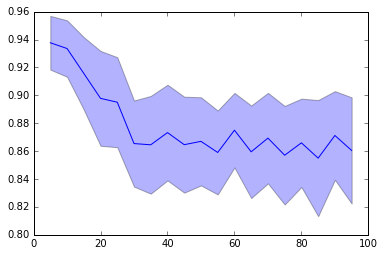

max: 85


In [216]:
print(sizes)
loss = (np.mean(score_loss,axis=1))
loss_std = (np.std(score_loss,axis=1))
plt.plot(sizes,loss)
plt.fill_between(sizes,loss-loss_std,loss+loss_std,alpha=0.3)
plt.show()
print("max: {}".format(sizes[np.argmin(loss,axis=0)]))

In [219]:
model = createModel([85,85])
train_scores,scores, proba_test,proba_y = crossValidate2(model,X_scaled,y,fold=5)

Train on 1213 samples, validate on 135 samples
Epoch 1/500
1213/1213 [==============================] - 0s - loss: 1.2856 - acc: 0.3504 - val_loss: 1.0621 - val_acc: 0.4296
Epoch 2/500
1213/1213 [==============================] - 0s - loss: 1.1599 - acc: 0.3800 - val_loss: 1.0528 - val_acc: 0.4519
Epoch 3/500
1213/1213 [==============================] - 0s - loss: 1.1504 - acc: 0.3850 - val_loss: 1.0486 - val_acc: 0.4963
Epoch 4/500
1213/1213 [==============================] - 0s - loss: 1.1287 - acc: 0.4114 - val_loss: 1.0430 - val_acc: 0.4593
Epoch 5/500
1213/1213 [==============================] - 0s - loss: 1.0971 - acc: 0.4303 - val_loss: 1.0358 - val_acc: 0.4889
Epoch 6/500
1213/1213 [==============================] - 0s - loss: 1.0686 - acc: 0.4427 - val_loss: 1.0410 - val_acc: 0.5185
Epoch 7/500
1213/1213 [==============================] - 0s - loss: 1.0767 - acc: 0.4633 - val_loss: 1.0328 - val_acc: 0.5185
Epoch 8/500
1213/1213 [==============================] - 0s - loss: 1.0

In [232]:
precisionMatrix(np.vstack(proba_test),np.vstack(proba_y))


,h_Correct,h_Wrong,h_Precent,d_Correct,d_Wrong,d_Precent,a_Correct,a_Wrong,a_Precent
>80,109,8,0.931624,2,0,1.000000,48,4,0.923077
60-80,161,57,0.738532,7,2,0.777778,82,26,0.759259
50-60,84,84,0.500000,14,7,0.666667,49,36,0.576471
40-50,113,141,0.444882,41,27,0.602941,44,46,0.488889
30-40,87,131,0.399083,95,170,0.358491,70,159,0.305677
20-30,26,116,0.183099,135,396,0.254237,91,253,0.264535
<20,16,215,0.069264,36,416,0.079646,38,402,0.086364
